[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tulasiram58827/craft_tflite/blob/main/colabs/savedmodel_to_tflite.ipynb)

This notebook converts tensorflow savel model to tflite version

## SetUp

In [90]:
"""
Authors
 * Tulasi Ram
"""
!pip install onnx
!pip install git+https://github.com/onnx/onnx-tensorflow.git

import onnx
import numpy as np
import os
import cv2
import time


import torch
from torch.autograd import Variable

from skimage import io
import tensorflow as tf
from onnx_tf.backend import prepare
from google.colab.patches import cv2_imshow

tf.__version__

  Cloning https://github.com/onnx/onnx-tensorflow.git to /tmp/pip-req-build-646l4nyh
  Running command git clone -q https://github.com/onnx/onnx-tensorflow.git /tmp/pip-req-build-646l4nyh
  Created wheel for onnx-tf: filename=onnx_tf-1.6.0-cp36-none-any.whl size=205527 sha256=adf1b1853a0bd544dbea36b9aa28972bc100f8055496701a1984d866dd0f3bd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-e4gjn3hc/wheels/54/24/31/8873b33d2d560efdfa1ed6f346df67ef793b1897358705a480
Successfully built onnx-tf


'2.3.0'

## Helper functions

In [91]:
def loadImage(img_file):
    img = io.imread(img_file)           # RGB order
    if img.shape[0] == 2: img = img[0]
    if len(img.shape) == 2 : img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:   img = img[:,:,:3]
    img = np.array(img)

    return img

def normalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy().astype(np.float32)

    img -= np.array([mean[0] * 255.0, mean[1] * 255.0, mean[2] * 255.0], dtype=np.float32)
    img /= np.array([variance[0] * 255.0, variance[1] * 255.0, variance[2] * 255.0], dtype=np.float32)
    return img

def denormalizeMeanVariance(in_img, mean=(0.485, 0.456, 0.406), variance=(0.229, 0.224, 0.225)):
    # should be RGB order
    img = in_img.copy()
    img *= variance
    img += mean
    img *= 255.0
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def resize_aspect_ratio(img, square_size, interpolation, mag_ratio=1):
    height, width, channel = img.shape

    # magnify image size
    target_size = mag_ratio * max(height, width)

    # set original image size
    if target_size > square_size:
        target_size = square_size
    
    ratio = target_size / max(height, width)    

    target_h, target_w = int(height * ratio), int(width * ratio)
    proc = cv2.resize(img, (target_w, target_h), interpolation = interpolation)


    # make canvas and paste image
    target_h32, target_w32 = target_h, target_w
    if target_h % 32 != 0:
        target_h32 = target_h + (32 - target_h % 32)
    if target_w % 32 != 0:
        target_w32 = target_w + (32 - target_w % 32)
    resized = np.zeros((target_h32, target_w32, channel), dtype=np.float32)
    resized[0:target_h, 0:target_w, :] = proc
    target_h, target_w = target_h32, target_w32

    size_heatmap = (int(target_w/2), int(target_h/2))

    return resized, ratio, size_heatmap

In [92]:
def saveResult(img_file, img, boxes, dirname='./result/', verticals=None, texts=None):
        """ save text detection result one by one
        Args:
            img_file (str): image file name
            img (array): raw image context
            boxes (array): array of result file
                Shape: [num_detections, 4] for BB output / [num_detections, 4] for QUAD output
        Return:
            None
        """
        img = np.array(img)

        # make result file list
        filename, file_ext = os.path.splitext(os.path.basename(img_file))

        # result directory
        res_file = dirname + "res_" + filename + '.txt'
        res_img_file = dirname + "res_" + filename + '.jpg'

        if not os.path.isdir(dirname):
            os.mkdir(dirname)
        #data = open('task3.txt', 'w')
        count = 0
        with open(res_file, 'w') as f:
            for i, box in enumerate(boxes):
                #text = save_polygon(img, box, count)
                #box_data = ""
                #for co_ord in box:
                #    box_data+=f"{co_ord[0]}, {co_ord[1]}"
                #print(box_data, text)
                #data.write(box_data+","+text+"\n")
                #count+=1
                poly = np.array(box).astype(np.int32).reshape((-1))
                #strResult = ','.join([str(p) for p in poly]) + '\r\n'
                #f.write(strResult)
                poly = poly.reshape(-1, 2)
                min_co = tuple(np.min(poly, axis=0))
                max_co = tuple(np.max(poly, axis=0))
                #x_1, x_2, y_1, y_2 = poly[0][0], poly[1][0], poly[1][1], poly[2][1]
                cv2.rectangle(img, min_co, max_co, (0, 0, 255), 2)
                #cv2.polylines(img, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
                ptColor = (0, 255, 255)
                if verticals is not None:
                    if verticals[i]:
                        ptColor = (255, 0, 0)

                if texts is not None:
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.5
                    cv2.putText(img, "{}".format(texts[i]), (poly[0][0]+1, poly[0][1]+1), font, font_scale, (0, 0, 0), thickness=1)
                    cv2.putText(img, "{}".format(texts[i]), tuple(poly[0]), font, font_scale, (0, 255, 255), thickness=1)

        # Save result image
        cv2.imwrite(res_img_file, img)

In [93]:
""" auxilary functions """
# unwarp corodinates
def warpCoord(Minv, pt):
    out = np.matmul(Minv, (pt[0], pt[1], 1))
    return np.array([out[0]/out[2], out[1]/out[2]])
""" end of auxilary functions """


def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text):
    # prepare data
    linkmap = linkmap.copy()
    textmap = textmap.copy()
    img_h, img_w = textmap.shape

    """ labeling method """
    ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
    ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

    text_score_comb = np.clip(text_score + link_score, 0, 1)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

    det = []
    mapper = []
    for k in range(1,nLabels):
        # size filtering
        size = stats[k, cv2.CC_STAT_AREA]
        if size < 10: continue

        # thresholding
        if np.max(textmap[labels==k]) < text_threshold: continue

        # make segmentation map
        segmap = np.zeros(textmap.shape, dtype=np.uint8)
        segmap[labels==k] = 255
        segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area
        x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
        w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
        niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
        sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
        # boundary check
        if sx < 0 : sx = 0
        if sy < 0 : sy = 0
        if ex >= img_w: ex = img_w
        if ey >= img_h: ey = img_h
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
        segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

        # make box
        np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
        rectangle = cv2.minAreaRect(np_contours)
        box = cv2.boxPoints(rectangle)

        # align diamond-shape
        w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
        box_ratio = max(w, h) / (min(w, h) + 1e-5)
        if abs(1 - box_ratio) <= 0.1:
            l, r = min(np_contours[:,0]), max(np_contours[:,0])
            t, b = min(np_contours[:,1]), max(np_contours[:,1])
            box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

        # make clock-wise order
        startidx = box.sum(axis=1).argmin()
        box = np.roll(box, 4-startidx, 0)
        box = np.array(box)

        det.append(box)
        mapper.append(k)

    return det, labels, mapper

def getPoly_core(boxes, labels, mapper, linkmap):
    # configs
    num_cp = 5
    max_len_ratio = 0.7
    expand_ratio = 1.45
    max_r = 2.0
    step_r = 0.2

    polys = []  
    for k, box in enumerate(boxes):
        # size filter for small instance
        w, h = int(np.linalg.norm(box[0] - box[1]) + 1), int(np.linalg.norm(box[1] - box[2]) + 1)
        if w < 10 or h < 10:
            polys.append(None); continue

        # warp image
        tar = np.float32([[0,0],[w,0],[w,h],[0,h]])
        M = cv2.getPerspectiveTransform(box, tar)
        word_label = cv2.warpPerspective(labels, M, (w, h), flags=cv2.INTER_NEAREST)
        try:
            Minv = np.linalg.inv(M)
        except:
            polys.append(None); continue

        # binarization for selected label
        cur_label = mapper[k]
        word_label[word_label != cur_label] = 0
        word_label[word_label > 0] = 1

        """ Polygon generation """
        # find top/bottom contours
        cp = []
        max_len = -1
        for i in range(w):
            region = np.where(word_label[:,i] != 0)[0]
            if len(region) < 2 : continue
            cp.append((i, region[0], region[-1]))
            length = region[-1] - region[0] + 1
            if length > max_len: max_len = length

        # pass if max_len is similar to h
        if h * max_len_ratio < max_len:
            polys.append(None); continue

        # get pivot points with fixed length
        tot_seg = num_cp * 2 + 1
        seg_w = w / tot_seg     # segment width
        pp = [None] * num_cp    # init pivot points
        cp_section = [[0, 0]] * tot_seg
        seg_height = [0] * num_cp
        seg_num = 0
        num_sec = 0
        prev_h = -1
        for i in range(0,len(cp)):
            (x, sy, ey) = cp[i]
            if (seg_num + 1) * seg_w <= x and seg_num <= tot_seg:
                # average previous segment
                if num_sec == 0: break
                cp_section[seg_num] = [cp_section[seg_num][0] / num_sec, cp_section[seg_num][1] / num_sec]
                num_sec = 0

                # reset variables
                seg_num += 1
                prev_h = -1

            # accumulate center points
            cy = (sy + ey) * 0.5
            cur_h = ey - sy + 1
            cp_section[seg_num] = [cp_section[seg_num][0] + x, cp_section[seg_num][1] + cy]
            num_sec += 1

            if seg_num % 2 == 0: continue # No polygon area

            if prev_h < cur_h:
                pp[int((seg_num - 1)/2)] = (x, cy)
                seg_height[int((seg_num - 1)/2)] = cur_h
                prev_h = cur_h

        # processing last segment
        if num_sec != 0:
            cp_section[-1] = [cp_section[-1][0] / num_sec, cp_section[-1][1] / num_sec]

        # pass if num of pivots is not sufficient or segment widh is smaller than character height 
        if None in pp or seg_w < np.max(seg_height) * 0.25:
            polys.append(None); continue

        # calc median maximum of pivot points
        half_char_h = np.median(seg_height) * expand_ratio / 2

        # calc gradiant and apply to make horizontal pivots
        new_pp = []
        for i, (x, cy) in enumerate(pp):
            dx = cp_section[i * 2 + 2][0] - cp_section[i * 2][0]
            dy = cp_section[i * 2 + 2][1] - cp_section[i * 2][1]
            if dx == 0:     # gradient if zero
                new_pp.append([x, cy - half_char_h, x, cy + half_char_h])
                continue
            rad = - math.atan2(dy, dx)
            c, s = half_char_h * math.cos(rad), half_char_h * math.sin(rad)
            new_pp.append([x - s, cy - c, x + s, cy + c])

        # get edge points to cover character heatmaps
        isSppFound, isEppFound = False, False
        grad_s = (pp[1][1] - pp[0][1]) / (pp[1][0] - pp[0][0]) + (pp[2][1] - pp[1][1]) / (pp[2][0] - pp[1][0])
        grad_e = (pp[-2][1] - pp[-1][1]) / (pp[-2][0] - pp[-1][0]) + (pp[-3][1] - pp[-2][1]) / (pp[-3][0] - pp[-2][0])
        for r in np.arange(0.5, max_r, step_r):
            dx = 2 * half_char_h * r
            if not isSppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_s * dx
                p = np.array(new_pp[0]) - np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    spp = p
                    isSppFound = True
            if not isEppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_e * dx
                p = np.array(new_pp[-1]) + np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    epp = p
                    isEppFound = True
            if isSppFound and isEppFound:
                break

        # pass if boundary of polygon is not found
        if not (isSppFound and isEppFound):
            polys.append(None); continue

        # make final polygon
        poly = []
        poly.append(warpCoord(Minv, (spp[0], spp[1])))
        for p in new_pp:
            poly.append(warpCoord(Minv, (p[0], p[1])))
        poly.append(warpCoord(Minv, (epp[0], epp[1])))
        poly.append(warpCoord(Minv, (epp[2], epp[3])))
        for p in reversed(new_pp):
            poly.append(warpCoord(Minv, (p[2], p[3])))
        poly.append(warpCoord(Minv, (spp[2], spp[3])))

        # add to final result
        polys.append(np.array(poly))

    return polys

def getDetBoxes(textmap, linkmap, text_threshold, link_threshold, low_text, poly=False):
    boxes, labels, mapper = getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text)

    if poly:
        polys = getPoly_core(boxes, labels, mapper, linkmap)
    else:
        polys = [None] * len(boxes)

    return boxes, polys

def adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net = 2):
    if len(polys) > 0:
        polys = np.array(polys)
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

### Export to Tensorflow Graph

In [94]:
# Export model to tensorflow

!wget https://github.com/tulasiram58827/craft_tflite/blob/main/models/craft.onnx?raw=true -O craft.onnx
onnx_model = onnx.load('/content/craft.onnx')

tf_rep = prepare(onnx_model)
tf_rep.export_graph('craft.pb')

print("Model converted to tensorflow graph succesfully.")

--2020-11-18 16:43:14--  https://github.com/tulasiram58827/craft_tflite/blob/main/models/craft.onnx?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tulasiram58827/craft_tflite/raw/main/models/craft.onnx [following]
--2020-11-18 16:43:15--  https://github.com/tulasiram58827/craft_tflite/raw/main/models/craft.onnx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tulasiram58827/craft_tflite/main/models/craft.onnx [following]
--2020-11-18 16:43:15--  https://raw.githubusercontent.com/tulasiram58827/craft_tflite/main/models/craft.onnx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... con

INFO:tensorflow:Assets written to: craft.pb/assets


Model converted to tensorflow graph succesfully.


### Convert to TFLite

In [95]:
!gdown https://drive.google.com/uc?id=1HvujMMNCG49esPpZOHEnPFY6k-khbrmZ
!unzip /content/image_files.zip
dataset_path = '/content/image_files/'


loaded = tf.saved_model.load('/content/craft.pb')

concrete_func = loaded.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

concrete_func.inputs[0].set_shape([None, 3, 800, 600])

converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])

converter.optimizations = [tf.lite.Optimize.DEFAULT]

Downloading...
From: https://drive.google.com/uc?id=1HvujMMNCG49esPpZOHEnPFY6k-khbrmZ
To: /content/image_files.zip
7.30MB [00:00, 11.8MB/s]
Archive:  /content/image_files.zip
replace image_files/000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: image_files/000.jpg     
  inflating: image_files/001.jpg     
  inflating: image_files/002.jpg     
  inflating: image_files/003.jpg     
  inflating: image_files/004.jpg     
  inflating: image_files/005.jpg     
  inflating: image_files/006.jpg     
  inflating: image_files/007.jpg     
  inflating: image_files/008.jpg     
  inflating: image_files/009.jpg     
  inflating: image_files/010.jpg     
  inflating: image_files/011.jpg     
  inflating: image_files/012.jpg     
  inflating: image_files/013.jpg     
  inflating: image_files/014.jpg     
  inflating: image_files/015.jpg     
  inflating: image_files/016.jpg     
  inflating: image_files/017.jpg     
  inflating: image_files/018.jpg     
  inflating: image_files/019.jpg  

In [96]:
def representative_data_gen():
    for file in os.listdir(dataset_path)[:10]:
        file_path = dataset_path+file
        image = loadImage(file_path)
        image = cv2.resize(image, dsize=(600, 800), interpolation=cv2.INTER_LINEAR)
        img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image, 800, interpolation=cv2.INTER_LINEAR, mag_ratio=1)
        ratio_h = ratio_w = 1 / target_ratio

        # preprocessing
        x = normalizeMeanVariance(image)
        x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
        x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
        x = x.cpu().detach().numpy()
        yield [x]

In [97]:
quantization = "float16" #@param ["dr", "int8", "float16"]

if quantization == 'float16':
    converter.target_spec.supported_types = [tf.float16]
elif quantization == 'int8':
    converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()

INFO:absl:Using experimental converter: If you encountered a problem please file a bug. You can opt-out by setting experimental_new_converter=False


In [98]:
open(f'craft_model_800_{quantization}.tflite', 'wb').write(tflite_model)
print("Converted to tensorflow lite succesfully.")

Converted to tensorflow lite succesfully.


In [99]:
!ls -lh craft_model_800_{quantization}.tflite

-rw-r--r-- 1 root root 40M Nov 18 16:43 craft_model_800_float16.tflite


In [100]:
!ls -lh craft.pb/saved_model.pb

-rw-r--r-- 1 root root 80M Nov 18 16:43 craft.pb/saved_model.pb


### TFLite Inference

In [101]:
def run_tflite_model(input_data):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=f"craft_model_800_{quantization}.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
 
    # Test the model on random input data.
    input_shape = input_details[0]['shape']
    # input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    y = interpreter.get_tensor(output_details[0]['index'])
    feature = interpreter.get_tensor(output_details[1]['index'])

    return y, feature

### Processing the inference results.

In [102]:
def cvt2HeatmapImg(img):
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img

In [103]:
import math

#Use any sample image.
image_path = '/content/image_files/000.jpg'
start_time = time.time()
image = loadImage(image_path)
image = cv2.resize(image, dsize=(600, 800), interpolation=cv2.INTER_LINEAR)
img_resized, target_ratio, size_heatmap = resize_aspect_ratio(image, 800, interpolation=cv2.INTER_LINEAR, mag_ratio=1)
ratio_h = ratio_w = 1 / target_ratio

# preprocessing
x = normalizeMeanVariance(image)
x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
# forward pass

x = x.cpu().detach().numpy()
y, feature = run_tflite_model(x)

y = torch.from_numpy(y)
feature = torch.from_numpy(feature)
# make score and link map
score_text = y[0,:,:,0].cpu().data.numpy()
score_link = y[0,:,:,1].cpu().data.numpy()

text_threshold = 0.7
link_threshold = 0.4
low_text = 0.4
poly = False

# Post-processing
boxes, polys = getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text, poly)

# coordinate adjustment
boxes = adjustResultCoordinates(boxes, ratio_w, ratio_h)
polys = adjustResultCoordinates(polys, ratio_w, ratio_h)
for k in range(len(polys)):
    if polys[k] is None: polys[k] = boxes[k]

# render results (optional)
render_img = score_text.copy()
render_img = np.hstack((render_img, score_link))
ret_score_text = cvt2HeatmapImg(render_img)


saveResult(image_path, image[:,:,::-1], polys, dirname='.')
filename, file_ext = os.path.splitext(os.path.basename(image_path))
print("Total time taken to run CRAFT tflite model......", time.time()-start_time)

(1, 3, 800, 600)
Total time taken to run CRAFT tflite model...... 7.803672552108765


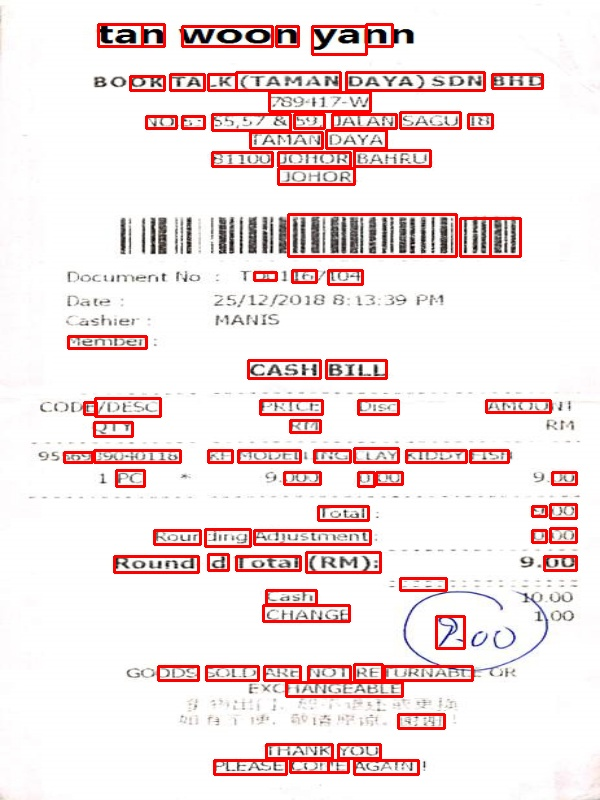

In [104]:
image = cv2.imread('/content/outputres_000.jpg')
cv2_imshow(image)